In [ ]:
import codecs
import os
import sys
import threading
import serial
from serial.tools.list_ports import comports

1. Gimbal control

In [10]:
from a2gmeasurements import GimbalRS2
import time, timeit
import numpy as np

myGimbal = GimbalRS2()
myGimbal.start_thread_gimbal()

Start receiving messages


Finding required time for gimbal to answer a position request

In [ ]:
from a2gmeasurements import GimbalRS2
import time, timeit
import numpy as np

myGimbal = GimbalRS2()
myGimbal.start_thread_gimbal()

assumed_time_for_execute_time = 0.0015 # s
gimbal_speed = (1800/3.47) # DEG/s
condition_continue = True
tol = gimbal_speed * assumed_time_for_execute_time
cnt = 0
myGimbal.request_current_position()
time.sleep(0.0015)
last_yaw = myGimbal.yaw 
last_roll = myGimbal.roll
print('Outside: ',last_yaw, last_roll)
myGimbal.setPosControl(yaw=1250, roll=0, pitch=0)
time.sleep(1)
while(condition_continue):
    print('Execution time: ', timeit.default_timer() - start)
    myGimbal.request_current_position()
    time.sleep(0.0015)
    print('Inside: ', myGimbal.yaw, myGimbal.roll)
    
    if np.abs(last_yaw - myGimbal.yaw) < tol and np.abs(last_roll - myGimbal.roll) < tol:
        condition_continue = False
    else:
        last_yaw = myGimbal.yaw
        last_roll = myGimbal.roll
        start = timeit.default_timer()
    cnt = cnt+1
    print(cnt)
    


In [20]:
#myGimbal.request_current_position()
myGimbal.setPosControl(yaw=0, roll=0, pitch=0)

Message sent on PCAN_USBBUS1

Message sent on PCAN_USBBUS1

Message sent on PCAN_USBBUS1

Message sent on PCAN_USBBUS1



True

In [21]:
myGimbal.stop_thread_gimbal()
time.sleep(0.05)
myGimbal.actual_bus.shutdown()

Stopped receiving messages


2. Anritsu Control

In [ ]:
from a2gmeasurements import myAnritsuSpectrumAnalyzer

mySA = myAnritsuSpectrumAnalyzer()
mySA.spectrum_analyzer_connect()
rx_power =  mySA.retrieve_max_pow()
print(rx_power)
mySA.spectrum_analyzer_close()

3. Septentrio Control

In [53]:
from a2gmeasurements import GpsSignaling
mySeptentrioGPS = GpsSignaling(DBG_LVL_2=True)

In [54]:
mySeptentrioGPS.serial_connect()
mySeptentrioGPS.serial_instance.reset_input_buffer()


In [ ]:
#mySeptentrioGPS.sendCommandGps(cmd='sga, MultiAntenna') # by default this is the command
mySeptentrioGPS.sendCommandGps(cmd='sgd, ETRS89')
mySeptentrioGPS.sendCommandGps(cmd='spm, Rover, RTK')

In [ ]:
mySeptentrioGPS.sendCommandGps(cmd='setNTRIPSettings, NTR1, Client, opencaster.nls.fi, 2101, fuave, v5E3oKu853A, VRS-FKP')

In [55]:

#mySeptentrioGPS.start_gps_data_retrieval(msg_type='NMEA', nmea_type='GGA', interval='sec1') # HDF instead of GGA for heading info
#mySeptentrioGPS.start_gps_data_retrieval(msg_type='NMEA', nmea_type='HDT', interval='sec1') # HDF instead of GGA for heading info

mySeptentrioGPS.start_gps_data_retrieval(msg_type='SBF', stream_number=1, interface='USB', interval='sec2')
mySeptentrioGPS.start_thread_gps()


In [ ]:
import struct
struct.calcsize('<1c3H1I1H2B3d5f1d1f4B2H1I2B4H1B')

In [57]:
mySeptentrioGPS.stop_gps_data_retrieval(stream_number=1, msg_type='SBF')
#mySeptentrioGPS.stop_gps_data_retrieval(msg_type='SBF')
mySeptentrioGPS.stop_thread_gps()

In [58]:
print(len(mySeptentrioGPS.SBF_frame_buffer), len(mySeptentrioGPS.NMEA_buffer))
if len(mySeptentrioGPS.SBF_frame_buffer) > 0:
    print(mySeptentrioGPS.SBF_frame_buffer[-1])
if len(mySeptentrioGPS.NMEA_buffer) > 0:
    print(mySeptentrioGPS.NMEA_buffer[-1])

21 0
{'ID': 'Heading', 'TOW': 118982000, 'WNc': 2251, 'ERR': 0, 'MODE': 2, 'Heading': 169.6487274169922, 'Pitch': -0.05587797611951828, 'Roll': -20000000000.0}


In [ ]:
mySeptentrioGPS.sendCommandGps('sdio, USB1,, -SBF-NMEA')

In [59]:
mySeptentrioGPS.serial_instance.close()

In [62]:
mySeptentrioGPS.SBF_frame_buffer

[{'ID': 'Coordinates',
  'TOW': 118960000,
  'WNc': 2251,
  'MODE': 1,
  'ERR': 0,
  'X': 2885668.616751026,
  'Y': 1334491.9205545222,
  'Z': 5510766.505916461,
  'Datum': 0},
 {'ID': 'Heading',
  'TOW': 118960000,
  'WNc': 2251,
  'ERR': 0,
  'MODE': 2,
  'Heading': 169.2756805419922,
  'Pitch': -0.01572183519601822,
  'Roll': -20000000000.0},
 {'ID': 'Coordinates',
  'TOW': 118962000,
  'WNc': 2251,
  'MODE': 1,
  'ERR': 0,
  'X': 2885668.675170647,
  'Y': 1334491.5537603002,
  'Z': 5510766.218123834,
  'Datum': 0},
 {'ID': 'Heading',
  'TOW': 118962000,
  'WNc': 2251,
  'ERR': 0,
  'MODE': 2,
  'Heading': 170.0293426513672,
  'Pitch': -0.4141693711280823,
  'Roll': -20000000000.0},
 {'ID': 'Coordinates',
  'TOW': 118964000,
  'WNc': 2251,
  'MODE': 1,
  'ERR': 0,
  'X': 2885668.72548534,
  'Y': 1334491.1555280697,
  'Z': 5510765.935835249,
  'Datum': 0},
 {'ID': 'Heading',
  'TOW': 118964000,
  'WNc': 2251,
  'ERR': 0,
  'MODE': 2,
  'Heading': 169.27476501464844,
  'Pitch': -0.005

In [ ]:
xsbf = mySeptentrioGPS.SBF_frame_buffer[-1]['X']
ybf = mySeptentrioGPS.SBF_frame_buffer[-1]['Y']
zbf = mySeptentrioGPS.SBF_frame_buffer[-1]['Z']

In [ ]:
lat=mySeptentrioGPS.NMEA_buffer[-1]['Latitude']
lon=mySeptentrioGPS.NMEA_buffer[-1]['Longitude']

In [ ]:
print(lat, lon)

Precision of distance when using planar coordinates ('precision' is given by google estimate of distance)

In [ ]:
import pyproj as proj
from a2gmeasurements import HelperA2GMeasurements
import numpy as np

pt_hammentie_50 = [60.186977663598164, 24.961182204780805]
pt_hakaniemi_mkt = [60.17907971164074, 24.951228689442726]

h = HelperA2GMeasurements()

lat_pln_hamm, lon_pln_hamm = h.convert_DDMMS_to_planar(24.961182204780805, 60.186977663598164)
lat_pln_hak, lon_pln_hak = h.convert_DDMMS_to_planar(24.951228689442726, 60.17907971164074)

# Compare this distance with Google MAPS: CHECKED ---> within 2m error
d_hamm_hak = np.linalg.norm(np.array([lon_pln_hamm, lat_pln_hamm]) - np.array([lon_pln_hak, lat_pln_hak]))

Example of a real GPS NMEA output

In [63]:
real_gps_data = {'Timestamp': '110815.00', 
                 'Latitude': '6011.1011606', 
                 'Latitude Direction': 'N', 
                 'Longitude': '02448.9144475', 
                 'Longitude Direction': 'E', 
                 'GPS Quality Indicator': '2', 
                 'Number of Satellites in use': '28', 
                 'Horizontal Dilution of Precision': '0.6', 
                 'Antenna Alt above sea level (mean)': '0.9230', 
                 'Units of altitude (meters)': 'M', 
                 'Geoidal Separation': '19.5883', 
                 'Units of Geoidal Separation (meters)': 'M', 
                 'Age of Differential GPS Data (secs)': '1.8', 
                 'Differential Reference Station ID': '0123'}

real_gps_sbf_data = {'TOW': 476864000, 'WNc': 2237, 'MODE': 1, 'ERR': 0, 
                     'X': 2885666.3154522795, 'Y': 1334484.5807205061, 'Z': 5510775.657593954, 
                     'Undulation': 19.586938858032227, 
                     'Vx': -0.0005603009485639632, 'Vy': 0.013242623768746853, 'Vz': 0.0013509213458746672, 
                     'COG': -20000000000.0, 'RxClkBias': 0.1324483297937943, 'RxClkDrift': 0.019449610263109207, 
                     'TimeSystem': 0, 'Datum': 0, 'NrSV': 12, 'WACorrInfo': 0, 'ReferenceID': 65535, 
                     'MeanCorrAge': 65535, 'SignalInfo': 807534857, 'AlertFlag': 1, 'NrBases': 0, 
                     'PPPInfo': 0, 'Latency': 64, 'HAccuracy': 1500, 'VAccuracy': 1471}

# Estos datos fueron tomados del Septentrio colocado en la ventana de mi oficina en Micronova
real_gps_sbf_data_1 = {'ID': 'Coordinates',
  'TOW': 118960000,
  'WNc': 2251,
  'MODE': 1,
  'ERR': 0,
  'X': 2885668.616751026,
  'Y': 1334491.9205545222,
  'Z': 5510766.505916461,
  'Datum': 0}

real_gps_sbf_data_2 = {'ID': 'Coordinates',
  'TOW': 118962000,
  'WNc': 2251,
  'MODE': 1,
  'ERR': 0,
  'X': 2885668.675170647,
  'Y': 1334491.5537603002,
  'Z': 5510766.218123834,
  'Datum': 0}

real_gps_sbf_data_3 = {'ID': 'Heading',
  'TOW': 118960000,
  'WNc': 2251,
  'ERR': 0,
  'MODE': 2,
  'Heading': 169.2756805419922,
  'Pitch': -0.01572183519601822,
  'Roll': -20000000000.0}

In [65]:
import a2gUtils as ag

lat, lon, h = ag.geocentric2geodetic(real_gps_sbf_data_2['X'], real_gps_sbf_data_2['Y'], real_gps_sbf_data_2['Z'])

print(lat, lon, h)

X, Y, Z = ag.geodetic2geocentric(lat, lon, h)

print(X, Y, Z)

60.18456654727771 24.818411540297028 41.664939670823514
2885668.675170647 1334491.5537603002 5510766.218123834


Server connection

In [ ]:
from socket import socket
import time
from a2gmeasurements import HelperA2GMeasurements

host = 'localhost'
myHelper = HelperA2GMeasurements('GROUND', host)
myHelper.HelperStartA2GCom()


In [ ]:
myHelper.HelperA2GStopCom()
print(myHelper.SOCKET_BUFFER, len(myHelper.SOCKET_BUFFER))

5. Signal generator

In [ ]:
import pyvisa

rm = pyvisa.ResourceManager()
print(rm.list_resources())

inst = rm.open_resource('GPIB0::19::INSTR')
print(inst.query("*IDN?"))

inst.write('F0 28.95 GH\n')
inst.write('L0 20 DM\n')

# Turn On RF output
inst.write('RF1\n')
# Turn Off RF output
inst.write('RF0\n')

In [ ]:
from a2gmeasurements import myAnritsuSpectrumAnalyzer

dir = 'C://Users//jvjulian//OneDrive - Teknologian Tutkimuskeskus VTT//Documents//Measurement 1//20221012133438//'
file = 'CONT20221012133504968.rsm'

anritsu = myAnritsuSpectrumAnalyzer()
anritsu.parse_xml_file(dir + file)
anritsu.XML_file

In [ ]:
from PyQt6.QtWidgets import QApplication, QLabel, QWidget
import sys

app = QApplication([])

window = QWidget()
window.setWindowTitle("PyQt App")
window.setGeometry(100, 600, 280, 280) # 1st: x coordinate, 2nd: y coordinate, 3rd: width, 4th: height
helloMsg = QLabel("<h1>Hello World</h1>", parent=window)
helloMsg.move(60, 15)
window.show()

sys.exit(app.exec())


In [ ]:
import datetime
import time
import sys

today_date = datetime.date.today()
today_date = [int(i) for i in today_date.strftime("%Y-%m-%d").split('-')]

ex = '110815.00'

print(today_date)

complete_date = datetime.datetime(year=today_date[0], 
                                  month=today_date[1], 
                                  day=today_date[2], 
                                  hour=int(ex[0:2]), 
                                  minute=int(ex[2:4]), 
                                  second=int(ex[4:6]))

a = time.mktime(complete_date.timetuple())
print(a)

print(time.time())

Animation to prove gimbal_follows_drone function does its job

HiQ: YAW: 520, PITCH: 26
FutHub: YAW: 690, PITCH: 31
FatLiz: YAW: 1710, PITCH: 63
AaltoMetro: YAW: -1574, PITCH: 37


c:\Users\jvjulian\OneDrive - Teknologian Tutkimuskeskus VTT\Documents\Aerial\Repos\a2gMeasurements\gps_visualization.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis1.set_xticklabels(self.x_ticks)
c:\Users\jvjulian\OneDrive - Teknologian Tutkimuskeskus VTT\Documents\Aerial\Repos\a2gMeasurements\gps_visualization.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis1.set_yticklabels(self.y_ticks)


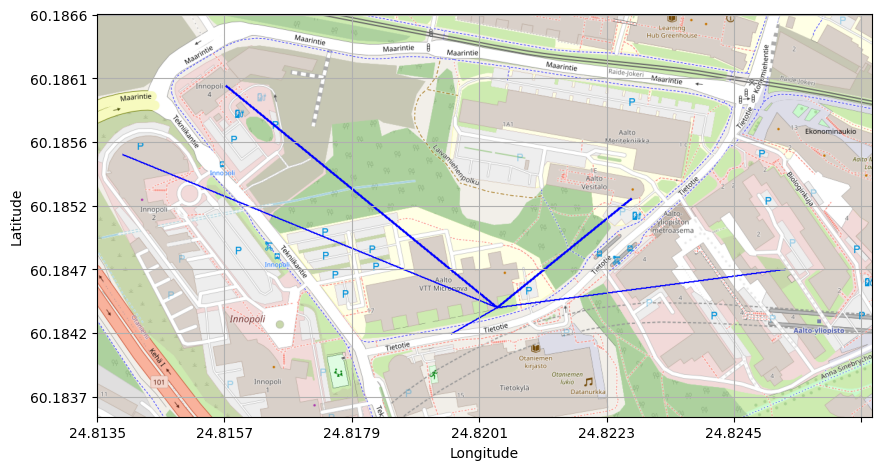

In [5]:
from pyproj import Transformer, Geod
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
from gps_visualization import GPSVis
from a2gmeasurements import HelperA2GMeasurements

upper_left = {'LAT': 60.1871, 'LON': 24.8113}
lower_right = {'LAT': 60.1837, 'LON': 24.8245}

hi_q = {'LAT': 60.18592, 'LON': 24.81174 }
fut_hub = {'LAT': 60.18650, 'LON': 24.81350}                        
fat_liz = {'LAT': 60.18555, 'LON': 24.82041}
aalto_metro = {'LAT':60.18495, 'LON': 24.82302}

micronova_office = {'LAT': 60.18463111366192, 'LON': 24.818124782978057}

wgs84_geod = Geod(ellps='WGS84')

transproj_1 = Transformer.from_crs({"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'}, "EPSG:4326", always_xy=True,)
transproj_2 = Transformer.from_crs("EPSG:4326", {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'})

x1, y1 = transproj_2.transform(fat_liz['LAT'], fat_liz['LON'])
x2, y2 = transproj_2.transform(aalto_metro['LAT'], aalto_metro['LON'])

az_fat_aalto,_, dist_fat_aalto = wgs84_geod.inv(fat_liz['LON'], fat_liz['LAT'], aalto_metro['LON'], aalto_metro['LAT'])
az_fat_hiq,_, dist_fat_hiq = wgs84_geod.inv(fat_liz['LON'], fat_liz['LAT'], hi_q['LON'], hi_q['LAT'])
az_fat_futhub,_, dist_fat_futhub = wgs84_geod.inv(fat_liz['LON'], fat_liz['LAT'], fut_hub['LON'], fut_hub['LAT'])
az_aalto_hiq,_, dist_aalto_hiq = wgs84_geod.inv(aalto_metro['LON'], aalto_metro['LAT'], hi_q['LON'], hi_q['LAT'])
az_aalto_futhub,_, dist_aalto_futhub = wgs84_geod.inv(aalto_metro['LON'], aalto_metro['LAT'], fut_hub['LON'], fut_hub['LAT'])
az_hiq_futhub,_, dist_hiq_futhub = wgs84_geod.inv(hi_q['LON'], hi_q['LAT'], fut_hub['LON'], fut_hub['LAT'])

'''
print(az_fat_aalto, dist_fat_aalto)
print(az_fat_hiq, dist_fat_hiq)
print(az_fat_futhub, dist_fat_futhub)
print(az_aalto_hiq, dist_aalto_hiq)
print(az_aalto_futhub, dist_aalto_futhub)
print(az_hiq_futhub, dist_hiq_futhub)
'''

heading = -120
myHelper = HelperA2GMeasurements(ID='GROUND', SERVER_ADDRESS='0.0.0.0')

yaw_hiq, pitch_hiq = myHelper.gimbal_follows_drone(heading=heading, lat_ground=micronova_office['LAT'], lon_ground=micronova_office['LON'], height_ground=2, lat_drone=hi_q['LAT'], lon_drone=hi_q['LON'], height_drone=20)
yaw_futhub, pitch_futhub = myHelper.gimbal_follows_drone(heading=heading, lat_ground=micronova_office['LAT'], lon_ground=micronova_office['LON'], height_ground=2, lat_drone=fut_hub['LAT'], lon_drone=fut_hub['LON'], height_drone=20)
yaw_fatliz, pitch_fatliz = myHelper.gimbal_follows_drone(heading=heading, lat_ground=micronova_office['LAT'], lon_ground=micronova_office['LON'], height_ground=2, lat_drone=fat_liz['LAT'], lon_drone=fat_liz['LON'], height_drone=20)
yaw_aaltometro, pitch_aalto_metro = myHelper.gimbal_follows_drone(heading=heading, lat_ground=micronova_office['LAT'], lon_ground=micronova_office['LON'], height_ground=2, lat_drone=aalto_metro['LAT'], lon_drone=aalto_metro['LON'], height_drone=20)

print('HiQ: YAW: ' + str(yaw_hiq) + ', PITCH: ' + str(pitch_hiq))
print('FutHub: YAW: ' + str(yaw_futhub) + ', PITCH: ' + str(pitch_futhub))
print('FatLiz: YAW: ' + str(yaw_fatliz) + ', PITCH: ' + str(pitch_fatliz))
print('AaltoMetro: YAW: ' + str(yaw_aaltometro) + ', PITCH: ' + str(pitch_aalto_metro))

vis = GPSVis(data_path='test_coordinates_map_micronova.csv',
             map_path='test_map_micronova.png',  # Path to map downloaded from the OSM.
             points=(upper_left['LAT'], upper_left['LON'], lower_right['LAT'], lower_right['LON'])) # Two coordinates of the map (upper left, lower right)

vis.create_image(color=(0, 0, 255), width=3, heading=heading)  # Set the color and the width of the GNSS tracks.
vis.plot_map(output='-')

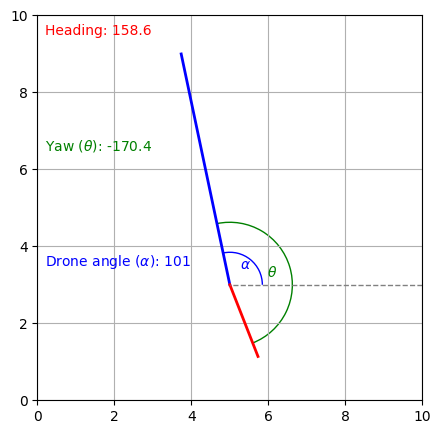

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
from a2gUtils import AngleAnnotation
from a2gmeasurements import HelperA2GMeasurements


myHelper = HelperA2GMeasurements(ID='GROUND', SERVER_ADDRESS='')

xlim = (0, 10)
ylim = (0, 10)

lon_ground_planar = (xlim[0] + xlim[1])/2
lat_ground_planar = 3
height_ground = 1

fig = plt.figure(figsize=((5, 5)))
ax = fig.add_subplot(111, aspect='equal', xlim=xlim, ylim=ylim)

ax.grid()


line1, = ax.plot([],[], lw=2, color='blue')
line2, = ax.plot([],[], lw=2, color='red')
line3, = ax.plot([],[], lw=1, color='gray', linestyle='--')
heading_angle_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, color='red')
yaw2set_text = ax.text(0.02, 0.65, '', transform=ax.transAxes, color='green')
angle_drone_wrt_horizontal_text = ax.text(0.02, 0.35, '', transform=ax.transAxes, color='blue')

def animate(i):
    lon_drone_planar = np.random.rand()*10
    lat_drone_planar = np.random.rand()*10
    
    heading = np.random.rand()*np.pi*2
      
    yaw, _, alpha = myHelper.ground_gimbal_follows_drone(heading=heading, 
                                                   lat_ground=lat_ground_planar, 
                                                   lon_ground=lon_ground_planar, 
                                                   height_ground=1, 
                                                   lat_drone=lat_drone_planar, 
                                                   lon_drone=lon_drone_planar, 
                                                   height_drone=10, 
                                                   coord_type='planar')
    
    line1.set_data([lon_drone_planar, lon_ground_planar], 
                  [lat_drone_planar, lat_ground_planar])
    
    if heading > np.pi:
        heading_wrt_long_axs = np.pi/2 - (heading - np.pi*2)
        if heading_wrt_long_axs > np.pi:
            heading_wrt_long_axs = heading_wrt_long_axs - np.pi*2
        elif heading_wrt_long_axs < -np.pi:
            heading_wrt_long_axs = heading_wrt_long_axs + np.pi*2
    else:
        heading_wrt_long_axs = np.pi/2 - heading
        if heading_wrt_long_axs > np.pi:
            heading_wrt_long_axs = heading_wrt_long_axs - np.pi*2
        elif heading_wrt_long_axs < -np.pi:
            heading_wrt_long_axs = heading_wrt_long_axs + np.pi*2
    
    x_heading = lon_ground_planar + 2*np.cos(heading_wrt_long_axs)
    y_heading = lat_ground_planar + 2*np.sin(heading_wrt_long_axs)
    
    line2.set_data([x_heading, lon_ground_planar], 
                   [y_heading, lat_ground_planar])
        
    heading_angle_text.set_text('Heading: %.1f' % np.rad2deg(heading))
    yaw2set_text.set_text('Yaw (' +  r"$\theta$"  + '): '  +  f"{float(yaw)/10}")
    angle_drone_wrt_horizontal_text.set_text('Drone angle (' + r"$\alpha$"  + '): ' + f"{int(np.rad2deg(alpha))}")
    
    if yaw > 0:
        am1 = AngleAnnotation((lon_ground_planar, lat_ground_planar), 
                          (lon_drone_planar, lat_drone_planar), (x_heading, y_heading),  
                          ax=ax, size=125, text=r"$\theta$", color='green', text_kw=dict(color="green"))
    else:
        am1 = AngleAnnotation((lon_ground_planar, lat_ground_planar), 
                          (x_heading, y_heading), (lon_drone_planar, lat_drone_planar), 
                          ax=ax, size=125, text=r"$\theta$", color='green', text_kw=dict(color="green"))
        
    if alpha > 0:        
        am2 = AngleAnnotation((lon_ground_planar, lat_ground_planar), 
                          (xlim[1], lat_ground_planar), (lon_drone_planar, lat_drone_planar),
                          ax=ax, size=65, text=r"$\alpha$", color='blue', text_kw=dict(color="blue"))
    else:
        am2 = AngleAnnotation((lon_ground_planar, lat_ground_planar), 
                          (lon_drone_planar, lat_drone_planar), (xlim[1], lat_ground_planar),
                          ax=ax, size=65, text=r"$\alpha$", color='blue', text_kw=dict(color="blue"))
    
    line3.set_data([xlim[1], lon_ground_planar], 
                   [lat_ground_planar, lat_ground_planar])
    
    return line1, line2, heading_angle_text, yaw2set_text

ani = animation.FuncAnimation(fig, animate, frames=10, interval=5, repeat=False)

ani.save('basic_animation_2.gif', dpi=300, writer=PillowWriter(fps=0.2))
#plt.show()

In [11]:
from pyproj import CRS, Transformer

a = {'X': 2885666.3154522795, 'Y': 1334484.5807205061, 'Z': 5510775.657593954}

geodet_crs = CRS.from_epsg(4979) # Geodetic (lat,lon,h) system
geocent_crs = CRS.from_epsg(4978) # Geocentric (X,Y,Z) system

# pyproj transformer object from geocentric to geodetic
geocent_to_geodet = Transformer.from_crs(geocent_crs, geodet_crs)


lat_lon = geocent_to_geodet.transform(a['X'],a['Y'],a['Z'])

print(lat_lon)

(60.184648143207625, 24.818315331415892, 47.33474831096828)


In [ ]:
import datetime
gps_data = {}
gps_data['Timestamp'] = ''
for i in datetime.datetime.utcnow().timetuple()[3:6]:
    tmp = str(i)
    if len(tmp) == 1:
        tmp = '0' + tmp
    gps_data['Timestamp'] = gps_data['Timestamp'] + tmp
gps_data['Timestamp'] = float(int(gps_data['Timestamp']))
print(gps_data)

In [17]:
import json
a = {'CMD_SOURCE': 'SETGIMBAL', 'TYPE': 'CMD', 'DATA': {'YAW': 1245.5, 'PITCH': -614}}
a = json.dumps(a)


b = json.loads(a)
b['DATA']['YAW'] 
     

Sending this:  (b'%', b'-', b'07', b'cmd', b';')
b'%-07cmd;'


1245.5

In [6]:
import time  
import threading
def display(msg):  
    print(msg + ' ' + time.strftime('%H:%M:%S'))  
  

class RepeatTimer(threading.Timer):  
    def run(self):  
        while not self.finished.wait(self.interval):  
            self.function(*self.args,**self.kwargs)  
            print(' ')  
##We are now creating a thread timer and controling it  
timer = RepeatTimer(0.07,display,['Repeating'])  
timer.start() #recalling run  
print('Threading started')  
time.sleep(1)#It gets suspended for the given number of seconds  
print('Threading finishing')  
timer.cancel()

Threading started
Repeating 11:00:08
 
Repeating 11:00:08
 
Repeating 11:00:08
 
Repeating 11:00:08
 
Repeating 11:00:08
 
Repeating 11:00:08
 
Repeating 11:00:08
 
Repeating 11:00:08
 
Repeating 11:00:08
 
Repeating 11:00:08
 
Threading finishingRepeating 11:00:08
 



In [8]:
available_bits = 8
b = 0xffff >> available_bits << available_bits
print(b)

65280


[ 1.        +0.j          0.33688985+0.94154407j -0.77301045+0.63439328j
 -0.85772861-0.51410274j  0.19509032-0.98078528j  0.98917651-0.14673047j
  0.47139674+0.88192126j -0.67155895+0.74095113j -0.92387953-0.38268343j
  0.04906767-0.99879546j]


c:\Users\jvjulian\MyInstalledPrograms\envs\gimbalRS2\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


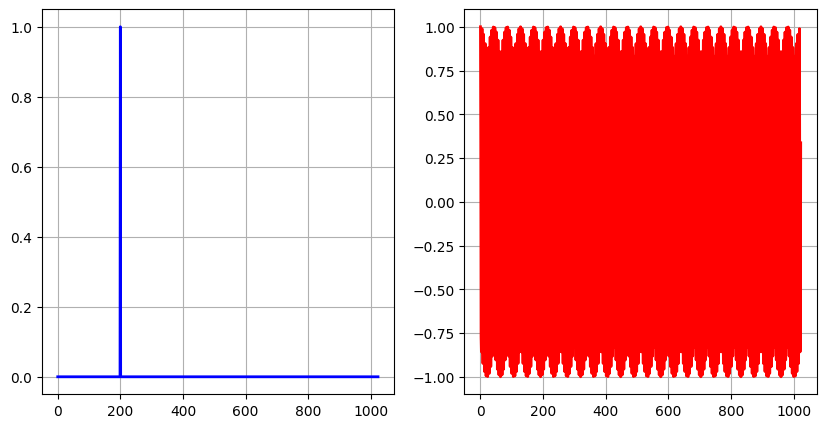

In [26]:
import numpy as np
import matplotlib.pyplot as plt

nfft = 1024
sc = 200

fd = np.zeros((nfft,), dtype='complex')
fd[(nfft >> 1) + sc] = 1
fd = np.fft.fftshift(fd, axes=0)

# Convert the waveform to time-domain
td = np.fft.ifft(fd, axis=0)

# Normalize the signal
td /= np.max([np.abs(td.real), np.abs(td.imag)])

print(td[0:10])

fig = plt.figure(figsize=((10, 5)))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.grid()
ax2.grid()

line1, = ax1.plot(fd, lw=2, color='blue')
line2, = ax2.plot(td, lw=2, color='red')

plt.show()


<class 'numpy.ndarray'> (1024,)


c:\Users\jvjulian\MyInstalledPrograms\envs\gimbalRS2\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


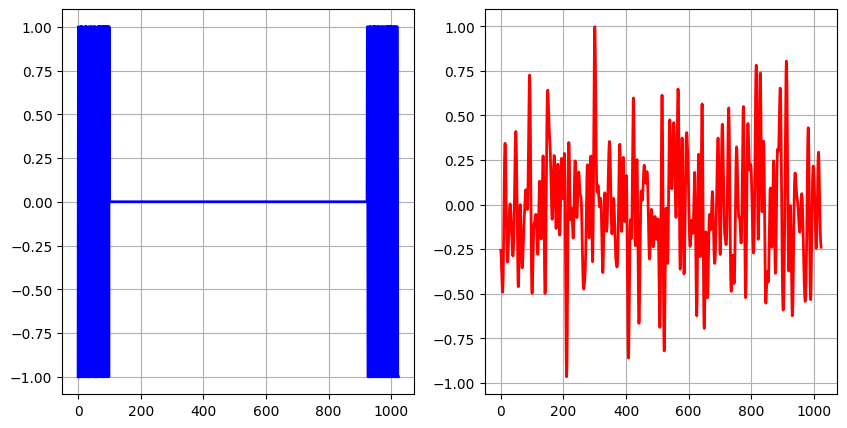

In [27]:
import numpy as np

nfft = 1024
sc_min = -100
sc_max = 100
mod = 'qam'
seed = 100

np.random.seed(seed)
qam = (1 + 1j, 1 - 1j, -1 + 1j, -1 - 1j)  # QAM symbols

# Create the wideband sequence in frequency-domain
fd = np.zeros((nfft,), dtype='complex')
if mod == 'qam':
    fd[((nfft >> 1) + sc_min):((nfft >> 1) + sc_max)] = np.random.choice(qam, len(range(sc_min, sc_max)))
else:
    fd[((nfft >> 1) + sc_min):((nfft >> 1) + sc_max)] = 1

fd = np.fft.fftshift(fd, axes=0)

# Convert the waveform to time-domain
td = np.fft.ifft(fd, axis=0)

# Normalize the signal
td /= np.max([np.abs(td.real), np.abs(td.imag)])

print(type(td), td.shape)

fig = plt.figure(figsize=((10, 5)))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.grid()
ax2.grid()

line1, = ax1.plot(fd, lw=2, color='blue')
line2, = ax2.plot(td, lw=2, color='red')

plt.show()

In [11]:
import plotly.express as px
import numpy as np 

theta = np.linspace(10, 30, 3)
dNLoS = np.linspace(20, 100, 9)

X, Y = np.meshgrid(theta, dNLoS)
Z = np.deg2rad(X)*Y # elementwise

fig = px.imshow(Z,
                labels=dict(x="", y="dNLoS [m]", color="hDrone"),
                x=[str(i) for i in theta],
                y=[str(i) for i in dNLoS]
               )
fig.update_xaxes(side="top")
#fig.show()

# Define dragmode, newshape parameters, amd add modebar buttons
fig.update_layout(
    dragmode='drawrect',
    newshape=dict(line_color='cyan'))
fig.show(config={'modeBarButtonsToAdd':['drawline',
                                        'drawopenpath',
                                        'drawclosedpath',
                                        'drawcircle',
                                        'drawrect',
                                        'eraseshape'
                                       ]})

In [ ]:
st = 0b1 
w1 = 0x0F
ep = 1
stop_bits = 0b00

st = 0b1 
w2 = 0xF8
ep = 0
stop_bits = 0b00

st = 0b1 
w3 = 0x3F
ep = 1
stop_bits = 0b00

st = 0b1 
w4 = 0x07
ep = 0
stop_bits = 0b00

st = 0b1 
w5 = 0x2B
ep = 1
stop_bits = 0b00

st = 0b1 
w6 = 0xFC
ep = 1
stop_bits = 0b00

st = 0b1 
w7 = 0x1B
ep = 1
stop_bits = 0b00

st = 0b1 
w8 = 0x71
ep = 1
stop_bits = 0b00

st = 0b1 
w9 = 0x95
ep = 1
stop_bits = 0b00

st = 0b1 
w10 = 0xED
ep = 1
stop_bits = 0b00

st = 0b1 
w11 = 0xC7
ep = 0
stop_bits = 0b00

st = 0b1 
w12 = 0xC1
ep = 0
stop_bits = 0b00

st = 0b1 
w13 = 0xF2
ep = 1
stop_bits = 0b00

st = 0b1 
w14 = 0xB2
ep = 0
stop_bits = 0b00

st = 0b1 
w15 = 0xDB
ep = 1
stop_bits = 0b00

st = 0b1 
w16 = 0xE0
ep = 0 
stop_bits = 0b00

st = 0b1 
w17 = 0xFC
ep = 1
stop_bits = 0b00

st = 0b1 
w18 = 0x1F
ep = 0
stop_bits = 0b00

st = 0b1 
w19 = 0x82
ep = 0
stop_bits = 0b00

st = 0b1 
w20 = 0x3E
ep = 1
stop_bits = 0b00

st = 0b1 
w21 = 0x0F
ep = 1
stop_bits = 0b00

st = 0b1 
w22 = 0xC1
ep = 0
stop_bits = 0b00

st = 0b1 
w23 = 0xFF
ep = 1
stop_bits = 0b00

st = 0b1 
w24 = 0xFF
ep = 1
stop_bits = 0b00

In [5]:
data1 = {'A': 100, 'E':3, 'T':-100, 'R': -2,
        '1': 0x0F, '2': 0xB7, '3': 0x1F, '4': 0x07,
        '5': 0x2B, '6': 0xFC, '7': 0x1F, '8': 0x83,
        '9':0x95, '10': 0xF2, '11': 0xBE, '12': 0x57,
        '13': 0x66, '14': 0xA2, '15': 0xDB, '16': 0xE0,
        '17': 0xFC, '18': 0x1F, '19': 0x83, '20': 0xF0,
        '21': 0x7E, '22': 0x0F, '23': 0xC1, '24': 0xFF, '25': 0xFF}

data2 = {'A': -100, 'E':3, 'T':-100, 'R': -2,
        '1': 0x0F, '2': 0x12, '3': 0xFF, '4': 0x07,
        '5': 0x2B, '6': 0xFC, '7': 0x1F, '8': 0x83,
        '9':0x95, '10': 0xF2, '11': 0xBE, '12': 0x57,
        '13': 0xA6, '14': 0xA2, '15': 0xDB, '16': 0xE0,
        '17': 0xFC, '18': 0x1F, '19': 0x83, '20': 0xF0,
        '21': 0x7E, '22': 0x0F, '23': 0xC1, '24': 0xFF, '25': 0xFF}

data3 = {'A': 50, 'E':3, 'T':-100, 'R': -2,
        '1': 0x0F, '2': 0x5F, '3': 0x5F, '4': 0x07,
        '5': 0x2B, '6': 0xFC, '7': 0x1F, '8': 0x83,
        '9':0x95, '10': 0xF2, '11': 0xBE, '12': 0x57,
        '13': 0xA6, '14': 0xA2, '15': 0xDB, '16': 0xE0,
        '17': 0xFC, '18': 0x1F, '19': 0x83, '20': 0xF0,
        '21': 0x7E, '22': 0x0F, '23': 0xC1, '24': 0xFF, '25': 0xFF}

data4 = {'A': -50, 'E':3, 'T':-100, 'R': -2,
        '1': 0x0F, '2': 0xFA, '3': 0xBF, '4': 0x07,
        '5': 0x2B, '6': 0xFC, '7': 0x1F, '8': 0x83,
        '9':0x95, '10': 0xF2, '11': 0xBE, '12': 0x57,
        '13': 0xA6, '14': 0xA2, '15': 0xDB, '16': 0xE0,
        '17': 0xFC, '18': 0x1F, '19': 0x83, '20': 0xF0,
        '21': 0x7E, '22': 0x0F, '23': 0xC1, '24': 0xFF, '25': 0xFF}

In [7]:
print( (data1['2'] | data1['3'] << 8) & 0x07FF)
print( (data2['2'] | data2['3'] << 8) & 0x07FF)

1975
1810


In [9]:
channel_sum = int.from_bytes(data1['2'], byteorder="little")
channel_sum



TypeError: cannot convert 'int' object to bytes